In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Load Data

In [2]:
# Load ESM2M labor capacity data
ds_esm2m = xr.open_dataset('../data/processed/GFDL/Monthly_Capacity/monthly_capacity_ens1-3_1950-2100.nc').rename({'__xarray_dataarray_variable__':'capacity'})

In [3]:
ds_hist  = ds_esm2m.sel(time=slice('1980-01-31','1999-12-31')).groupby('time.month')

In [10]:
# Calculate 1980-2000 baseline capacity, by month (mean - 2*std)
ds_hist_mean = ds_hist.mean(['time','ensemble'])
ds_dev = 2*ds_hist.std(['time','ensemble'])
ds_base = (ds_hist_mean - ds_dev)['capacity']

In [12]:
# Shorten capacity dataset to 2000-2100
ds_esm2m = ds_esm2m.sel(time=slice('2000-01-31',None))

In [13]:
# Broadcast monthly baseline over time dimension as another variable in dataset
ds_esm2m['baseline'] = ds_base.sel(month=ds_esm2m['time.month'],lat=ds_esm2m['lat'],lon=ds_esm2m['lon'])

In [14]:
def emergence(ds,start_year):
    ds_thres = ds.nonzero()
    
    # If non-empty, index + startyear = ToE
    if len(ds_thres[0]) > 0:
        return start_year+(ds_thres[0][0].item())
    
    # If empty, return year after 2100
    return 2101

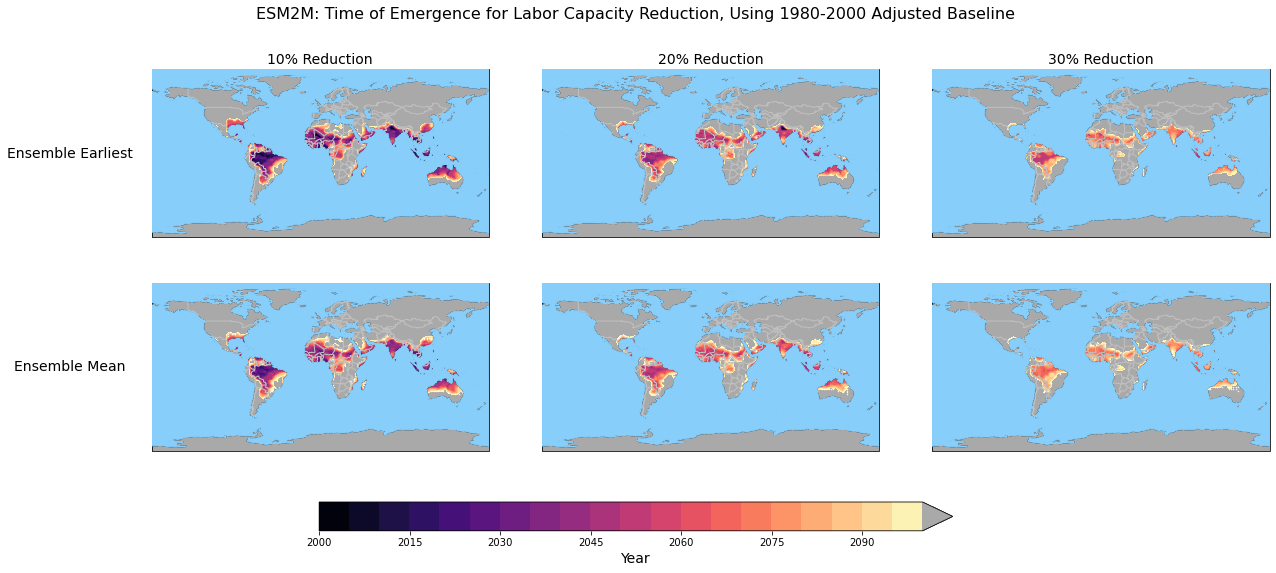

In [15]:
ds_thres_90 = ds_esm2m['capacity']<(0.9*ds_esm2m['baseline'])
ds_thres_90 = ds_thres_90.groupby('time.year').sum() > 3

ds_thres_80 = ds_esm2m['capacity']<(0.8*ds_esm2m['baseline'])
ds_thres_80 = ds_thres_80.groupby('time.year').sum() > 3

ds_thres_70 = ds_esm2m['capacity']<(0.7*ds_esm2m['baseline'])
ds_thres_70 = ds_thres_70.groupby('time.year').sum() > 3

# Calculate ToE for different thresholds
start_year = ds_esm2m['time.year'][0].item()
ds_90 = xr.apply_ufunc(emergence,ds_thres_90,input_core_dims=[['year']],vectorize=True,kwargs={'start_year':start_year})
ds_80 = xr.apply_ufunc(emergence,ds_thres_80,input_core_dims=[['year']],vectorize=True,kwargs={'start_year':start_year})
ds_70 = xr.apply_ufunc(emergence,ds_thres_70,input_core_dims=[['year']],vectorize=True,kwargs={'start_year':start_year})

# Specify projection
crs = ccrs.PlateCarree()

# Create figure and axes
fig, axs = plt.subplots(ncols=4,nrows=2,figsize=(22,8),subplot_kw={'projection':crs},gridspec_kw={'width_ratios': [0.5,3,3,3]})
levels = np.linspace(2000,2100,21)
cmap = 'magma'

# Plots of ToE: earliest among ensemble members
im = lf.contour(ds_90.min(dim='ensemble'),'10% Reduction',axs[0][1],levels=levels,cmap =cmap,label='Year',extend='max')
lf.contour(ds_80.min(dim='ensemble'),'20% Reduction',axs[0][2],levels=levels,cmap =cmap,label='Year',extend='max')
lf.contour(ds_70.min(dim='ensemble'),'30% Reduction',axs[0][3],levels=levels,cmap =cmap,label='Year',extend='max')

# Plots of ToE: mean among ensemble members
lf.contour(ds_90.mean(dim='ensemble'),None,axs[1][1],levels=levels,cmap =cmap,label='Year',extend='max')
lf.scatter(ds_90,axs[1][1])
lf.contour(ds_80.mean(dim='ensemble'),None,axs[1][2],levels=levels,cmap =cmap,label='Year',extend='max')
lf.scatter(ds_80,axs[1][2])
lf.contour(ds_70.mean(dim='ensemble'),None,axs[1][3],levels=levels,cmap =cmap,label='Year',extend='max')
lf.scatter(ds_70,axs[1][3])

# Annotating text
axs[0][0].text(0.5,0.5,'Ensemble Earliest',fontsize=14,horizontalalignment='center',verticalalignment='center');
axs[0][0].set_frame_on(False)
axs[1][0].text(0.5,0.5,'Ensemble Mean',fontsize=14,horizontalalignment='center',verticalalignment='center');
axs[1][0].set_frame_on(False)

# Single colorbar for all plots
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.3, 0.07, 0.4, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal');
cbar.set_label('Year',fontsize=14)

fig.suptitle('ESM2M: Time of Emergence for Labor Capacity Reduction, Using 1980-2000 Adjusted Baseline',fontsize=16);